In [1]:
import os
import time
import logging
from datetime import datetime
from collections import defaultdict

import numpy as np

import torch

from .evaluate.evaluate import evaluate, evaluate_classic, evaluate_prediction

from .model.model import load_VCI

from .dataset.dataset import load_dataset_splits, load_dataset_train_test

from .utils.general_utils import initialize_logger, ljson
from .utils.data_utils import data_collate

In [2]:
## load the datasets
datapath = "/path/to/your/data"
datasets = load_dataset_train_test(
        datapath,
        sample_cf=True
    )

In [3]:
import argparse
artifact =  "/path/to/your/model"
parser = argparse.ArgumentParser()
# setting arguments
parser.add_argument("--name", default="hdac_single_32")
parser.add_argument("--data_path", default = datapath, type=str)
parser.add_argument("--artifact_path", type=str,default=artifact)
parser.add_argument("--cpu", action="store_true")
parser.add_argument("--gpu", default="0")

# model arguments
parser.add_argument("--omega0", type=float, default=1.0, help="weight for individual-specific log-likelihood")
parser.add_argument("--omega1", type=float, default=5.0, help="weight for covariate-specific log-likelihood")
parser.add_argument("--omega2", type=float, default=5.0, help="weight for negative Kullback–Leibler divergence")
parser.add_argument("--omega3", type=float, default=0.1, help="weight for permutation discriminator")
parser.add_argument("--dist_mode", type=str, default="match", help="discriminate;fit;match")
parser.add_argument("--dist_outcomes", type=str, default="normal", help="nb;zinb;normal")
parser.add_argument("--hparams", type=str, default="hparams_pair_10X32T.json")
parser.add_argument("--distance", type=str, default="single", help="cosine;concat;element;single")
parser.add_argument("--split", type=str, default="new_split", help="split, new_split")
parser.add_argument("--covariate_keys", type=str, default="covariates")
parser.add_argument("--perturbation_key", type=str, default="Agg_Treatment")

# training arguments
parser.add_argument("--seed", type=int, default=None)
parser.add_argument("--batch_size", type=int, default=2048)
parser.add_argument("--max_epochs", type=int, default=1500)
parser.add_argument("--patience", type=int, default=20)
parser.add_argument("--checkpoint_freq", type=int, default=20)
parser.add_argument("--eval_mode", type=str, default="native", help="classic;native")
parser.add_argument("--adv_epoch", type=int, default=8)


args = dict(vars(parser.parse_args([])))

args["num_outcomes"] = datasets["train"].num_outcomes
args["num_treatments"] = datasets["train"].num_treatments
args["num_covariates"] = datasets["train"].num_covariates

## load the model 

In [4]:
modelpath = "path/to/trained/model"


state_dict = torch.load(modelpath)

In [5]:
from .train.train import prepare
model, datasets = prepare(args, state_dict[0])

## Load Representations

In [ ]:
import numpy as np
ZXs = []
ZTs = []
ZXTs = []
index = 1
for data in datasets["loader_tr"]:
    print(index, end=" ")
    (genes, perts, cf_genes, cf_perts, covariates) = (
            data[0], data[1], data[2], data[3], data[4:])

    ZX, ZXT, ZT = model.get_latent_presentation(genes, perts, covariates, sample=True, sigma1=2e-1, sigma2=5e-3, sigma3=1e-3)
    ZXs.extend(ZX)
    ZTs.extend(ZT)
    ZXTs.extend(ZXT)
    index += 1


In [ ]:
ZXs = [e.detach().cpu().numpy() for e in ZXs]
ZXs = np.array(ZXs)

ZXTs = [e.detach().cpu().numpy() for e in ZXTs]
ZXTs = np.array(ZXTs)

ZTs = [e.detach().cpu().numpy() for e in ZTs]
ZTs = np.array(ZTs)

## Load the RAW data to ADATA

In [9]:
import scanpy as sc
adata = sc.read(datapath)


In [64]:
adata.obsm["ZXs"] = ZXs
adata.obsm["ZTs"] = ZTs
adata.obsm["ZXTs"] = ZXTs


## Plot the Zx

In [118]:
sc.pp.neighbors(adata, use_rep="ZXs")
sc.tl.umap(adata, min_dist=0.3)
adata.obs["vehicle"] = adata.obs["vehicle"].astype(str)
adata.obs["cell_type"] = adata.obs["cell_type"].astype(str)
# adata.obs["dose"] = adata.obs["dose"].astype(str)

In [16]:
def combine_cov(row):
    celltypes = row["cell_type"]
    replicate = row["replicate"]
    return celltypes+'_'+replicate

adata.obs["covariate"] = adata.obs.apply(combine_cov, axis=1)

In [111]:
sc.set_figure_params(dpi=80, dpi_save=600, format='png')

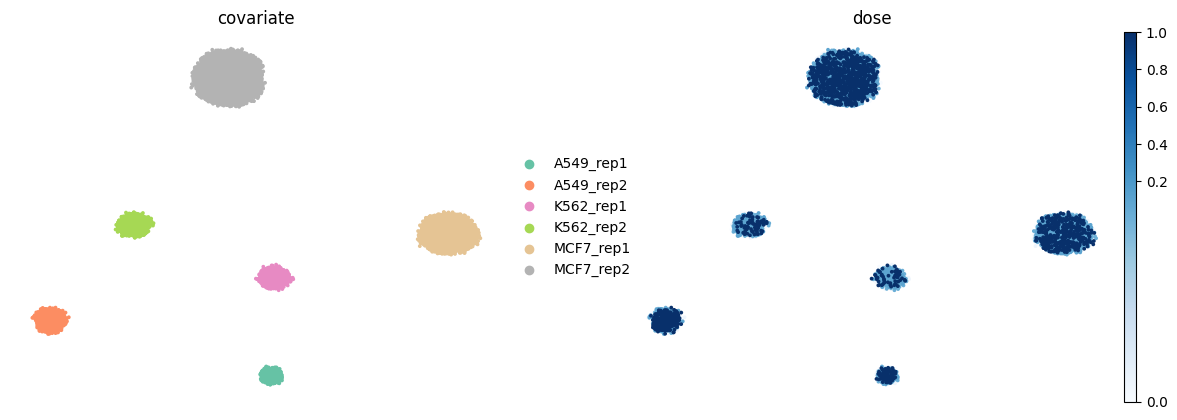

In [66]:
sc.pl.umap(
    adata,
    color=["covariate", "dose"],
    frameon=False,
    palette = "Set2",
    size = 30,
    outline_color= "gray",
    outline_width = 30,
    color_map = 'Blues',
    vcenter=0.01,

)

## Plot The Ztx

In [115]:
sc.pp.neighbors(adata, use_rep="ZXTs")
sc.tl.umap(adata,min_dist=0.5)

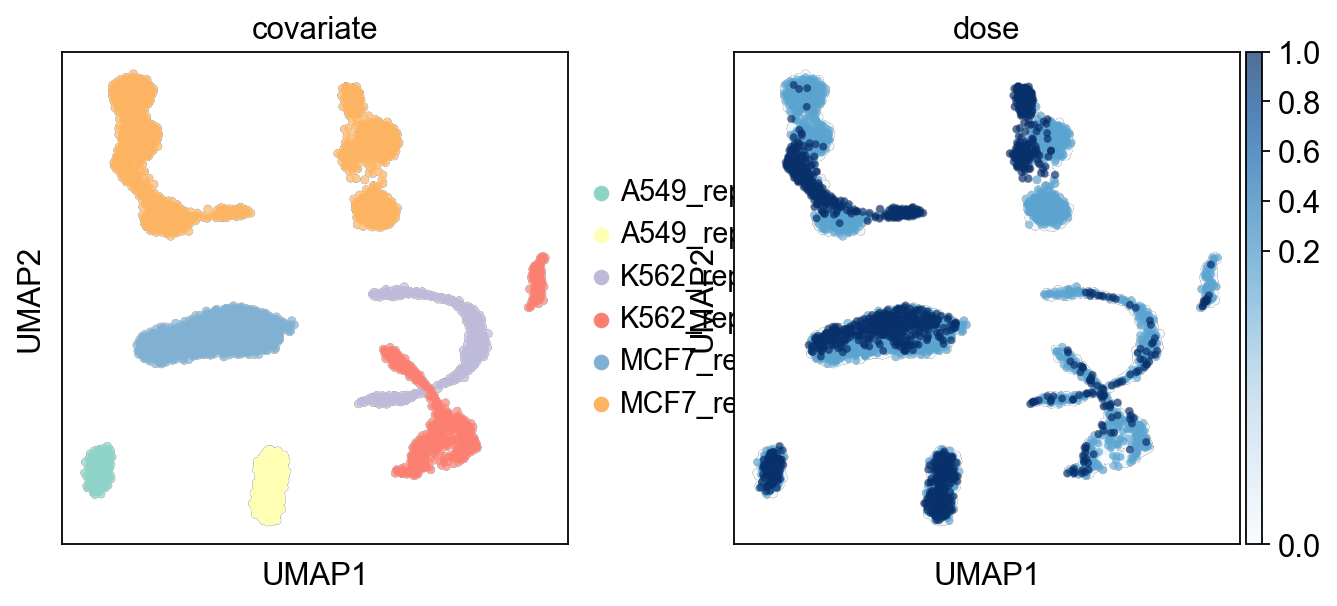

In [117]:
umap_kwargs = dict(
    add_outline=True, outline_width=(0.05,0), outline_color=('grey', 'white'))
sc.pl.umap(
        adata,
        color=["covariate", "dose"],
        frameon=True,
        palette = sns.color_palette('Set3'),
        size = 50,
        color_map = 'Blues',
        vcenter=0.01,**umap_kwargs)


## Plot Zt

In [96]:
sc.pp.neighbors(adata, use_rep="ZTs")

In [97]:
sc.tl.umap(adata, min_dist=0.5)

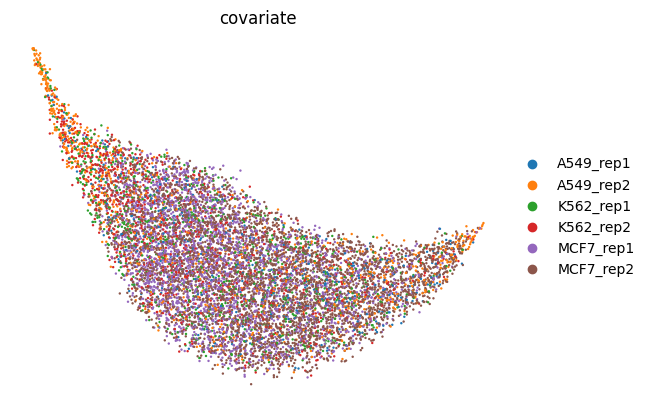

In [43]:
sc.pl.umap(
    adata,
    color=["covariate"],
    frameon=False)

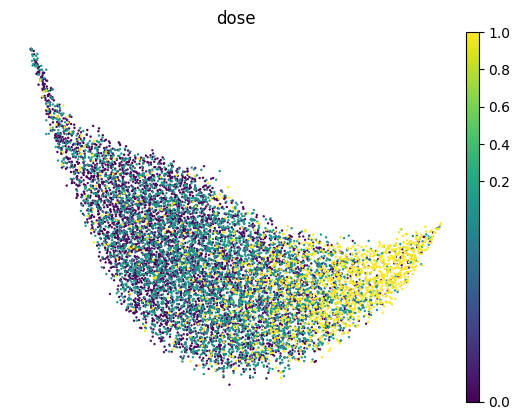

In [44]:
sc.pl.umap(
    adata,
    color=["dose"],
    vcenter=0.01,
    frameon=False)

## Evaluation Metrics

## Clustering Results

In [181]:
## Leiden clustering with latent representations
sc.pp.neighbors(adata, use_rep="ZXs")
sc.tl.leiden(adata)

In [112]:
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi
from sklearn.metrics import adjusted_rand_score as ari

In [113]:
def change_cov_pert(row):
    cov_pert = row["cov_pert_name"].split("_")
    treatment = row["Agg_Treatment"]
    dose = row["dose"]
    cov_pert[-1] = treatment
    cov_pert.append(str(dose))
    return "_".join(cov_pert)

change_cov_pert(adata.obs.iloc[1])


'MCF7_rep2_HDAC_1.0'

In [114]:
adata.obs.cov_pert_name = adata.obs.apply(lambda row: change_cov_pert(row), axis=1)

## ZX clustering results

In [182]:
nmivalue = nmi(adata.obs.covariate.to_numpy(), adata.obs.leiden.to_numpy())
print(nmivalue)

0.8863428628937162


In [183]:
arivalue = ari(adata.obs.covariate.to_numpy(), adata.obs.leiden.to_numpy())
print(arivalue)

0.8238444574513598


In [184]:
nmivalue = nmi(adata.obs.dose.to_numpy(), adata.obs.leiden.to_numpy())
print(nmivalue)

0.09829543937340746


In [185]:
arivalue = ari(adata.obs.dose.to_numpy(), adata.obs.leiden.to_numpy())
print(arivalue)

0.05301747408077814


In [186]:
nmivalue = nmi(adata.obs.cov_pert_name.to_numpy(), adata.obs.leiden.to_numpy())
print(nmivalue)
arivalue = ari(adata.obs.cov_pert_name.to_numpy(), adata.obs.leiden.to_numpy())
print(arivalue)

0.6511332989518566
0.31726414919247337


## ZT clustering results

In [187]:
sc.pp.neighbors(adata, use_rep="ZTs")
sc.tl.leiden(adata)

In [188]:
nmivalue = nmi(adata.obs.covariate.to_numpy(), adata.obs.leiden.to_numpy())
print(nmivalue)
arivalue = ari(adata.obs.covariate.to_numpy(), adata.obs.leiden.to_numpy())
print(arivalue)

0.5619585830678413
0.1395229654570747


In [189]:
nmivalue = nmi(adata.obs.dose.to_numpy(), adata.obs.leiden.to_numpy())
print(nmivalue)
arivalue = ari(adata.obs.dose.to_numpy(), adata.obs.leiden.to_numpy())
print(arivalue)

0.27583042876320196
0.06860050247808464


In [190]:
nmivalue = nmi(adata.obs.cov_pert_name.to_numpy(), adata.obs.leiden.to_numpy())
print(nmivalue)
arivalue = ari(adata.obs.cov_pert_name.to_numpy(), adata.obs.leiden.to_numpy())
print(arivalue)

0.646582288990604
0.29361767026155716


## ZXT clustering results

In [191]:
sc.pp.neighbors(adata, use_rep="ZXTs")
sc.tl.leiden(adata)

In [192]:
nmivalue = nmi(adata.obs.covariate.to_numpy(), adata.obs.leiden.to_numpy())
print(nmivalue)
arivalue = ari(adata.obs.covariate.to_numpy(), adata.obs.leiden.to_numpy())
print(arivalue)

0.7923130132865274
0.5441595967472919


In [193]:
nmivalue = nmi(adata.obs.dose.to_numpy(), adata.obs.leiden.to_numpy())
print(nmivalue)
arivalue = ari(adata.obs.dose.to_numpy(), adata.obs.leiden.to_numpy())
print(arivalue)

0.2253500405576085
0.0880559105845019


In [194]:
nmivalue = nmi(adata.obs.cov_pert_name.to_numpy(), adata.obs.leiden.to_numpy())
print(nmivalue)
arivalue = ari(adata.obs.cov_pert_name.to_numpy(), adata.obs.leiden.to_numpy())
print(arivalue)

0.7177526301183345
0.3721521537956975
